In [1]:
import torch
import numpy as np
import scipy
import pytorch_lightning as pl
from tqdm import tqdm

import matplotlib.pyplot as plt

import os, sys
sys.path.append('../../mist-base/GW')
sys.path.append('../../mist-base/')
sys.path.append('../../mist-base/utils')
sys.path.append('../../')

from src.utils.generators import Simulator_Additive
from simulators.utils import *
from utils.data import OnTheFlyDataModule, StoredDataModule
from utils.module import CustomLossModule_withBounds, BCELossModule

import logging
logging.getLogger('matplotlib.font_manager').disabled = True

mycolors = ['#570f6d', '#bb3754', '#f98e08']

0.2,False
simulating with a fraction 0.2
prob 0.2


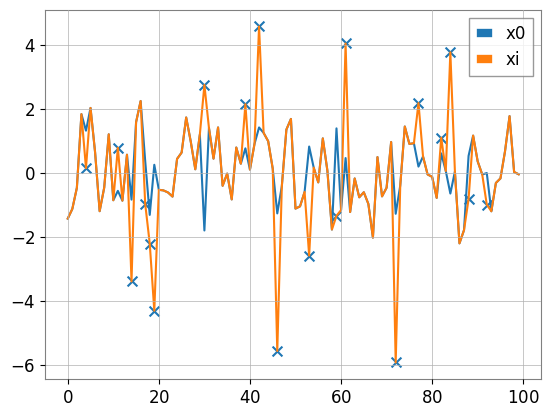

In [19]:
Nsims = 100_000
Nbins = 100
SIGMA = 1 # Likelihood covariance \Sigma = sigma * \mathbb{1}
simulator = Simulator_Additive(Nbins=Nbins, sigma=SIGMA, bounds=5, fraction=0.2, bkg=True, dtype=torch.float64, mode='white')     
samples = simulator.sample(Nsims=Nsims)  

plt.plot(samples['x0'][0], label='x0')
plt.plot(samples['xi'][0], label='xi')
idx = torch.where(samples['ni'][0] != 0)
plt.scatter(idx, samples['xi'][0][idx], marker='x', s=50)
plt.legend();

In [20]:
from models.online_norm import OnlineStandardizingLayer
from models.resnet_1d import ResidualNet

class Network_epsilon(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.logvariance = torch.nn.Parameter(torch.ones(Nbins)*5)
        self.net = ResidualNet(1, 1, hidden_features=128, num_blocks=2, kernel_size=1, padding=0) 

    def forward(self, x):
        data = x['x']
        x = self.net(data.unsqueeze(1)).squeeze(1)
        return x
                
    def epsilon(self, x):
        x = self.net(x.unsqueeze(1)).squeeze(1) # x-net
        return x
    
    def snr(self, x):
        return self.epsilon(x) / self.logvariance.exp().sqrt()  # [B, N_bins]
    
    def bounds(self):
        return self.logvariance.detach().exp().sqrt().mean(-1) * 5
        
    def forward(self, x):
        
        # Adaptive data generation
        ni = x['ni']
        epsilon_sim =  (2 * self.bounds() * torch.rand(x['x'].shape, device= x['x'].device, dtype= x['x'].dtype) - self.bounds()) * ni
        data =  x['x0'] + epsilon_sim * ni
        
        # data = x['x']
        epsilon = self.epsilon(data)
        mask = ( x['ni'] != 0 )  
        squared_error = (epsilon - epsilon_sim)**2                                                  # [B, N_bins]
        l = squared_error / (self.logvariance.exp() + 1e-10) + self.logvariance                     # [B, N_bins]
        return (l * mask.float()).sum() * 0.5

In [30]:
# # Train
# def resample(sample):
#     sample = simulator._resample(sample)
#     sample['x'] = sample['xi']
#     # sample = {k: v[0] for k, v in sample.items()}
#     return sample

batch_size = 32
samples = simulator.sample(Nsims=Nsims)  
# dm = StoredDataModule(samples, batch_size=batch_size, on_after_load_sample=resample)
dm = OnTheFlyDataModule(simulator, Nsims_per_epoch=400*batch_size, batch_size=batch_size)
network_epsilon = Network_epsilon()
model = CustomLossModule_withBounds(network_epsilon, learning_rate=3e-3)
trainer = pl.Trainer(
    accelerator="gpu", 
    max_epochs=20, 
    precision=64,
    # fast_dev_run=True
)
trainer.fit(model, dm)
network_epsilon.cuda().eval();

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | Network_epsilon | 66.5 K | train
--------------------------------------------------
66.5 K    Trainable params
0         Non-trainable params
66.5 K    Total params
0.266     Total estimated model params size (MB)
15        Modules in train mode
0         Modules in eval mode


0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2


Training: |          | 0/? [00:00<?, ?it/s]

0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2



Detected KeyboardInterrupt, attempting graceful shutdown ...


0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2
0.2,False
simulating with a fraction 0.2
prob 0.2


NameError: name 'exit' is not defined

IndexError: index 4 is out of bounds for dimension 0 with size 1

In [27]:
dm.data.items

<function dict.items>